<a href="https://colab.research.google.com/github/srimayamohapatra/-GIS-Workflows-for-Earth-Science/blob/main/Cyclone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio numpy matplotlib scipy

In [ ]:
import rasterio
import numpy as np
import scipy
import matplotlib

print("All libraries installed successfully!")
print(f"Rasterio Version: {rasterio.__version__}")
print(f"Numpy Version: {np.__version__}")

All libraries installed successfully!
Rasterio Version: 1.4.4
Numpy Version: 2.0.2


In [ ]:
import numpy as np
from scipy.ndimage import generic_filter

# --- 1. SETUP FILENAMES ---
# Make sure these match exactly what you see in your folder
file_before = "1403extratced.tif"  # Note the spelling from your screenshot
file_after  = "1805extracted.tif"

✅ Loaded Before Cyclone (14 March): 7980x12316 pixels
✅ Loaded After Cyclone (18 May): 7777x12534 pixels


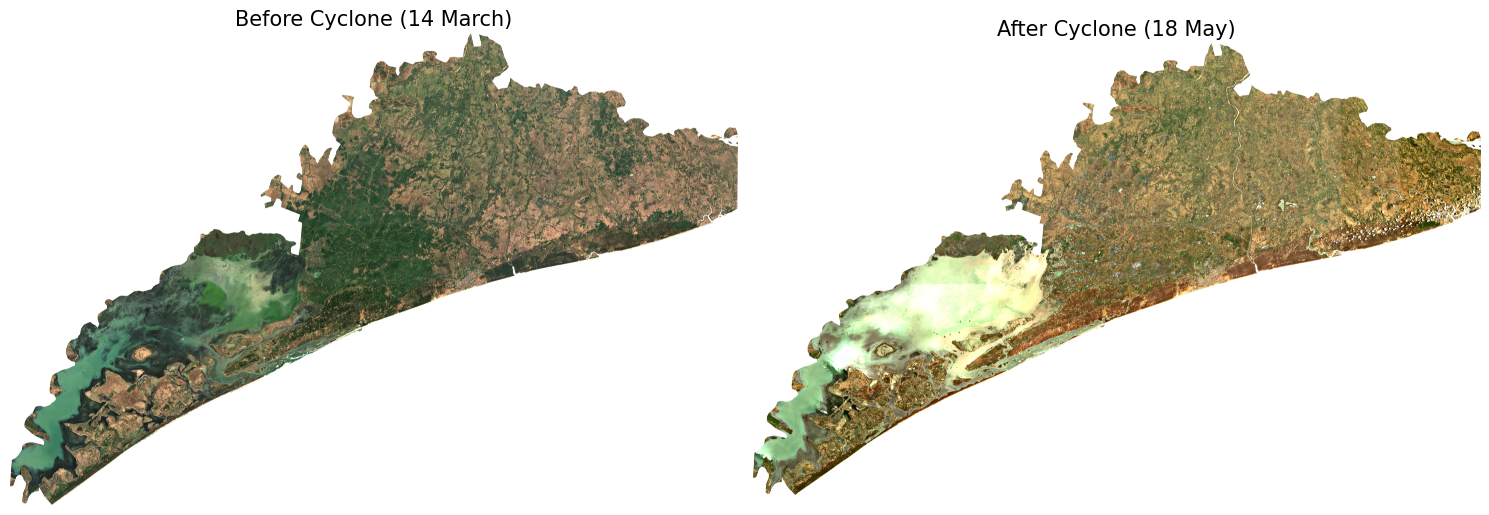

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- File Names ---
file_before = "1403extratced.tif"
file_after  = "1805extracted.tif"

def plot_image(ax, file_path, title):
    """Reads and displays a Tiff file on the given axis."""
    try:
        with rasterio.open(file_path) as src:
            # Read the first 3 bands (Red, Green, Blue)
            img = src.read([1, 2, 3])

            # Matplotlib needs image data in (Height, Width, Bands) format
            # Rasterio gives (Bands, Height, Width), so we swap axes
            img_display = np.moveaxis(img, 0, -1)

            # Normalization: Satellite data can be > 255 or float.
            # We scale it to 0-1 range for safe plotting
            if img_display.dtype == np.uint8:
                img_display = img_display.astype(float) / 255.0
            else:
                # If 16-bit or float, normalize by max value
                img_display = img_display.astype(float) / np.max(img_display)

            # Brighten the image slightly for display (optional)
            img_display = np.clip(img_display * 1.2, 0, 1)

            ax.imshow(img_display)
            ax.set_title(title, fontsize=15)
            ax.axis('off')
            print(f"✅ Loaded {title}: {img.shape[1]}x{img.shape[2]} pixels")

    except FileNotFoundError:
        print(f"❌ Error: Could not find file {file_path}")
        ax.text(0.5, 0.5, "File Not Found", ha='center', va='center')

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_image(ax1, file_before, "Before Cyclone (14 March)")
plot_image(ax2, file_after,  "After Cyclone (18 May)")

plt.tight_layout()
plt.show()

In [ ]:
import rasterio
import numpy as np
from scipy.ndimage import uniform_filter
import gc # Garbage Collector to free RAM

# --- CONFIGURATION ---
file_before = "1403extratced.tif"
file_after  = "1805extracted.tif"

def calculate_texture_fast(band_array):
    """
    Fast Texture: Uses Variance = Mean(X^2) - Mean(X)^2
    """
    band_float = band_array.astype(np.float32)
    mean = uniform_filter(band_float, size=3)
    sq_mean = uniform_filter(band_float**2, size=3)
    variance = sq_mean - mean**2
    return np.sqrt(np.maximum(variance, 0))

def process_memory_safe(input_file, output_file):
    print(f"Processing {input_file} (Memory Safe Mode)...")

    with rasterio.open(input_file) as src:
        profile = src.profile
        # Update profile for 5 bands
        profile.update(count=5, dtype=rasterio.float32, compress='lzw')

        # Read ONLY RGB first to save RAM
        # We read as float32 immediately to avoid duplicating arrays later
        img = src.read([1, 2, 3])

        with rasterio.open(output_file, 'w', **profile) as dst:
            print("   1. Writing Bands 1, 2, 3 (RGB)...")
            dst.write(img[0].astype(rasterio.float32), 1)
            dst.write(img[1].astype(rasterio.float32), 2)
            dst.write(img[2].astype(rasterio.float32), 3)

            # --- 2. Calculate & Write VARI (Band 4) ---
            print("   2. Calculating VARI...")
            R = img[0].astype(np.float32)
            G = img[1].astype(np.float32)
            B = img[2].astype(np.float32)

            # VARI Formula
            vari = (G - R) / (G + R - B + 0.00001)

            print("   ...Writing VARI to disk...")
            dst.write(vari, 4)

            # DELETE variables to free RAM immediately
            del vari, R, B
            gc.collect() # Force Python to clear memory

            # --- 3. Calculate & Write Texture (Band 5) ---
            print("   3. Calculating Texture (on Green band)...")
            # We still have 'G' in memory, let's use it
            texture = calculate_texture_fast(G)

            print("   ...Writing Texture to disk...")
            dst.write(texture, 5)

            # Clean up everything
            del texture, G, img
            gc.collect()

    print(f"✅ Finished: {output_file}")

# --- EXECUTE ---
process_memory_safe(file_before, "enhanced_before.tif")
process_memory_safe(file_after,  "enhanced_after.tif")
print("Done! This should have taken less than 2 minutes.")

Processing 1403extratced.tif (Memory Safe Mode)...
   1. Writing Bands 1, 2, 3 (RGB)...
   2. Calculating VARI...
   ...Writing VARI to disk...
   3. Calculating Texture (on Green band)...
   ...Writing Texture to disk...
✅ Finished: enhanced_before.tif
Processing 1805extracted.tif (Memory Safe Mode)...
   1. Writing Bands 1, 2, 3 (RGB)...
   2. Calculating VARI...
   ...Writing VARI to disk...
   3. Calculating Texture (on Green band)...
   ...Writing Texture to disk...
✅ Finished: enhanced_after.tif
Done! This should have taken less than 2 minutes.


Generating Feature Dashboard... (This will be fast)


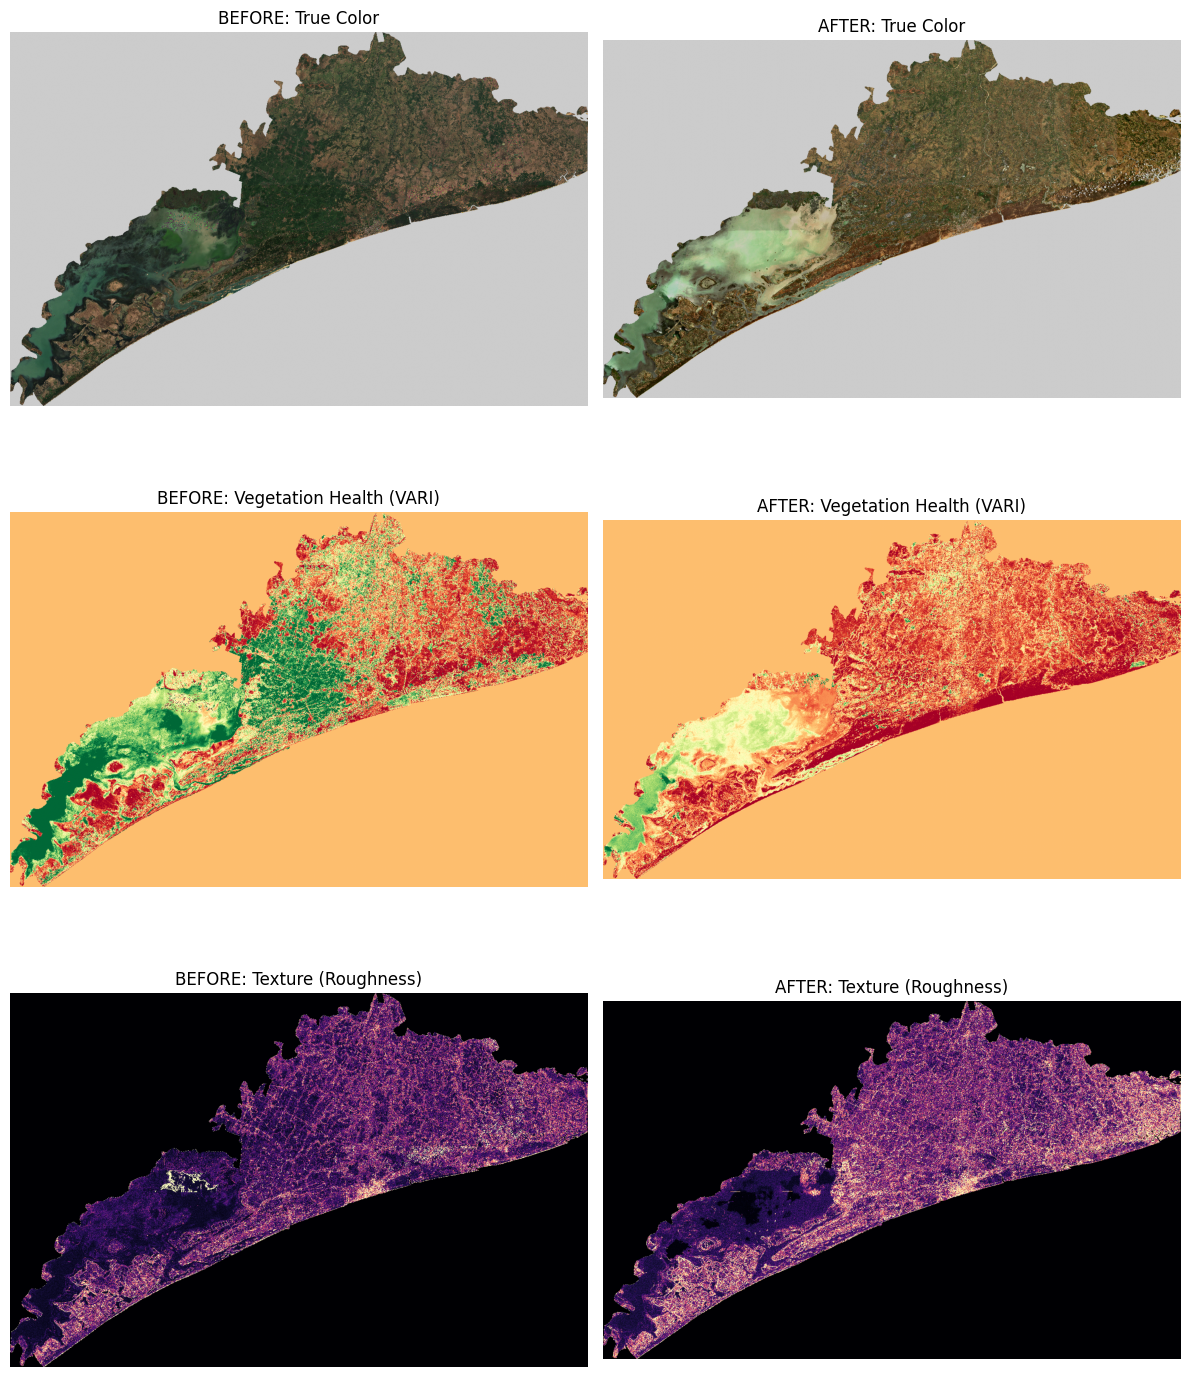

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
file_before = "enhanced_before.tif"
file_after  = "enhanced_after.tif"

def read_for_plot(file_path, scale_factor=10):
    """
    Reads the file but 'downsamples' it (takes every 10th pixel)
    so it plots instantly without crashing RAM.
    """
    with rasterio.open(file_path) as src:
        # Read bands. Recall: 1=R, 2=G, 3=B, 4=VARI, 5=Texture
        # We slice [::scale, ::scale] to reduce size
        r = src.read(1)[::scale_factor, ::scale_factor]
        g = src.read(2)[::scale_factor, ::scale_factor]
        b = src.read(3)[::scale_factor, ::scale_factor]
        vari = src.read(4)[::scale_factor, ::scale_factor]
        tex  = src.read(5)[::scale_factor, ::scale_factor]

        # Normalize RGB for display
        rgb = np.dstack((r, g, b))
        rgb = rgb.astype(float) / 255.0
        rgb = np.clip(rgb * 0.8, 0, 1) # Slightly darken for contrast

        return rgb, vari, tex

print("Generating Feature Dashboard... (This will be fast)")

# 1. Read Data
rgb_b, vari_b, tex_b = read_for_plot(file_before)
rgb_a, vari_a, tex_a = read_for_plot(file_after)

# 2. Setup Plot (3 Rows, 2 Columns)
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

# --- ROW 1: RGB (Real Color) ---
ax[0, 0].imshow(rgb_b)
ax[0, 0].set_title("BEFORE: True Color")
ax[0, 0].axis('off')

ax[0, 1].imshow(rgb_a)
ax[0, 1].set_title("AFTER: True Color")
ax[0, 1].axis('off')

# --- ROW 2: VARI (Vegetation Health) ---
# We use 'RdYlGn' colormap: Red=Low(Soil), Green=High(Veg)
# vmin/vmax controls contrast. VARI usually is between -0.5 and 0.5
ax[1, 0].imshow(vari_b, cmap='RdYlGn', vmin=-0.2, vmax=0.4)
ax[1, 0].set_title("BEFORE: Vegetation Health (VARI)")
ax[1, 0].axis('off')

ax[1, 1].imshow(vari_a, cmap='RdYlGn', vmin=-0.2, vmax=0.4)
ax[1, 1].set_title("AFTER: Vegetation Health (VARI)")
ax[1, 1].axis('off')

# --- ROW 3: Texture (Roughness) ---
# We use 'magma' colormap: Black=Smooth(Water), Orange/White=Rough(Debris)
# vmin/vmax might need tuning based on your specific image
ax[2, 0].imshow(tex_b, cmap='magma', vmin=0, vmax=20)
ax[2, 0].set_title("BEFORE: Texture (Roughness)")
ax[2, 0].axis('off')

ax[2, 1].imshow(tex_a, cmap='magma', vmin=0, vmax=20)
ax[2, 1].set_title("AFTER: Texture (Roughness)")
ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# --- CONFIGURATION ---
reference_file = "enhanced_before.tif"  # The "Master" image
input_file     = "enhanced_after.tif"   # The image to fix
output_file    = "enhanced_after_ALIGNED.tif"

print("--- Aligning Images (This is crucial) ---")

with rasterio.open(reference_file) as src_ref:
    # Get the "Master" metadata
    ref_profile = src_ref.profile
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    ref_width = src_ref.width
    ref_height = src_ref.height

    print(f"Reference Size: {ref_height} x {ref_width}")

    with rasterio.open(input_file) as src_mov:
        print(f"Input Size:     {src_mov.height} x {src_mov.width}")
        print("   ...Resampling 'After' image to match 'Before' image...")

        # Prepare the output array (5 bands, matching reference size)
        # We use float32 as that is what your enhanced data is
        destination = np.zeros((5, ref_height, ref_width), dtype=np.float32)

        # Reproject every band
        for i in range(1, 6): # Bands 1 to 5
            reproject(
                source=rasterio.band(src_mov, i),
                destination=destination[i-1], # Python index is 0-based
                src_transform=src_mov.transform,
                src_crs=src_mov.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.nearest # Use 'nearest' to preserve sharp edges
            )

        # Update metadata for the new aligned file
        ref_profile.update(count=5, dtype=rasterio.float32, compress='lzw')

        # Save
        with rasterio.open(output_file, 'w', **ref_profile) as dst:
            dst.write(destination)

print(f"✅ Alignment Complete. Saved: {output_file}")
print("You can now run the Damage Analysis code using this new file.")

--- Aligning Images (This is crucial) ---
Reference Size: 7980 x 12316
Input Size:     7777 x 12534
   ...Resampling 'After' image to match 'Before' image...
✅ Alignment Complete. Saved: enhanced_after_ALIGNED.tif
You can now run the Damage Analysis code using this new file.


Loading images for inspection...
Reading enhanced_before.tif...
   Shape: 7980 x 12316
Reading enhanced_after_ALIGNED.tif...
   Shape: 7980 x 12316


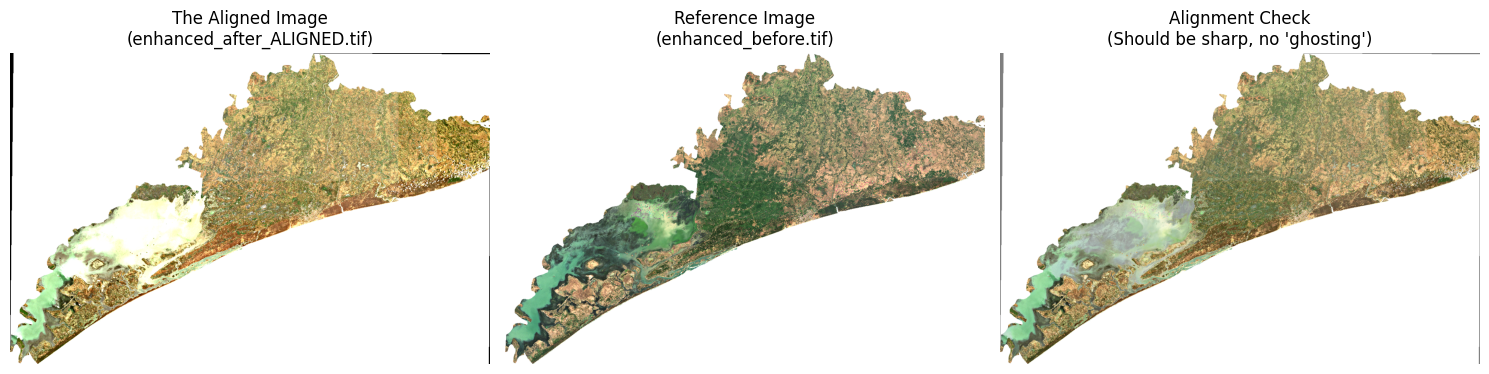


✅ Verification:
1. Look at the 'Alignment Check' panel.
2. If borders/roads look sharp (single lines), alignment is perfect.
3. If you see 'double vision' (two borders), alignment failed.


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
file_ref = "enhanced_before.tif"           # Master image
file_new = "enhanced_after_ALIGNED.tif"    # The aligned image you want to see

def read_rgb_preview(file_path, scale=10):
    """
    Reads RGB bands (1, 2, 3) and downsamples for fast viewing.
    """
    try:
        with rasterio.open(file_path) as src:
            print(f"Reading {file_path}...")
            print(f"   Shape: {src.height} x {src.width}")

            # Read Red, Green, Blue (Bands 1, 2, 3)
            # Downsample (::scale) to save RAM
            r = src.read(1)[::scale, ::scale]
            g = src.read(2)[::scale, ::scale]
            b = src.read(3)[::scale, ::scale]

            # Stack and Normalize
            rgb = np.dstack((r, g, b))

            # Normalize to 0-1 range
            # (Assuming Float32 data from previous steps)
            if rgb.max() > 1:
                rgb = rgb / 255.0

            # Brighten slightly and clip
            rgb = np.clip(rgb * 1.5, 0, 1)

            return rgb

    except Exception as e:
        print(f"❌ Error reading {file_path}: {e}")
        return None

# --- LOAD IMAGES ---
print("Loading images for inspection...")
img_before = read_rgb_preview(file_ref)
img_after  = read_rgb_preview(file_new)

if img_before is not None and img_after is not None:
    # --- PLOT ---
    plt.figure(figsize=(15, 6))

    # 1. Show the New Aligned Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_after)
    plt.title("The Aligned Image\n(enhanced_after_ALIGNED.tif)")
    plt.axis('off')

    # 2. Show the Reference Image
    plt.subplot(1, 3, 2)
    plt.imshow(img_before)
    plt.title("Reference Image\n(enhanced_before.tif)")
    plt.axis('off')

    # 3. Show Alignment Check (Overlay)
    # We create a 'Difference' image.
    # If aligned, edges (like coastlines) should look sharp, not blurry.
    plt.subplot(1, 3, 3)
    # Simple blend: 50% Before + 50% After
    blend = (img_before * 0.5 + img_after * 0.5)
    plt.imshow(blend)
    plt.title("Alignment Check\n(Should be sharp, no 'ghosting')")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\n✅ Verification:")
    print("1. Look at the 'Alignment Check' panel.")
    print("2. If borders/roads look sharp (single lines), alignment is perfect.")
    print("3. If you see 'double vision' (two borders), alignment failed.")

--- Starting Damage Analysis ---
   Input 1: enhanced_before.tif
   Input 2: enhanced_after_ALIGNED.tif
   ...Reading Pre-Cyclone Vegetation Index...
   ...Reading Post-Cyclone Bands...
   ...Detecting Vegetation Loss...
   ...Detecting Flood Areas...
   ...Creating Final Classification Map...

   DAMAGE ASSESSMENT REPORT
   Vegetation Loss: 33982.46 Hectares
   Flooded Area:    114340.14 Hectares

   Saving Final_Cyclone_Damage_Map.tif...
✅ Map Saved Successfully.
   Generating Preview Plot...


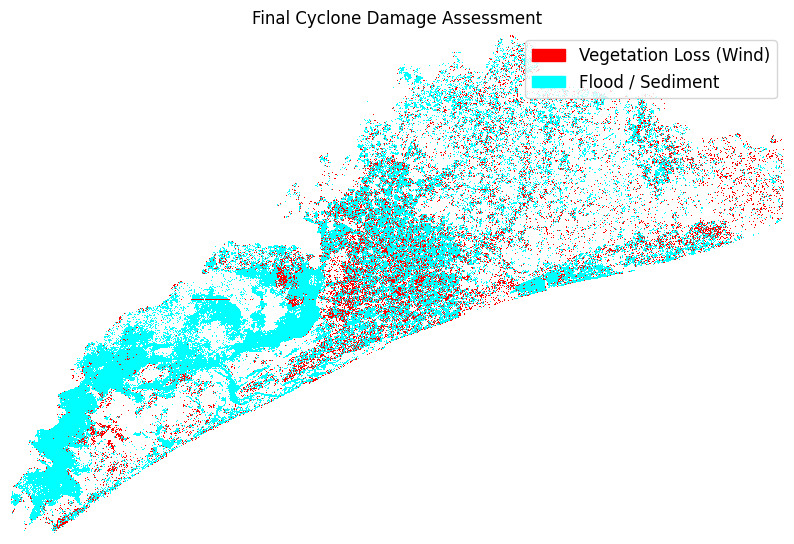

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# --- 1. CONFIGURATION ---
# We use the files you specifically requested
file_before = "enhanced_before.tif"
file_after  = "enhanced_after_ALIGNED.tif"
output_map  = "Final_Cyclone_Damage_Map.tif"

# Resolution in meters (Sentinel-2 = 10m). Adjust if using different data.
PIXEL_SIZE = 10

print(f"--- Starting Damage Analysis ---")
print(f"   Input 1: {file_before}")
print(f"   Input 2: {file_after}")

# --- 2. LOAD DATA (Memory Safe Mode) ---
# We read only specific bands to keep RAM usage low
try:
    with rasterio.open(file_before) as src_b:
        profile = src_b.profile # Save metadata for the output file
        # Read VARI (Band 4) -> Python Index 3
        print("   ...Reading Pre-Cyclone Vegetation Index...")
        vari_before = src_b.read(4)

    with rasterio.open(file_after) as src_a:
        # Read Red (Band 1), VARI (Band 4), Texture (Band 5)
        print("   ...Reading Post-Cyclone Bands...")
        red_after  = src_a.read(1)
        vari_after = src_a.read(4)
        tex_after  = src_a.read(5)

    # --- 3. DAMAGE LOGIC ---

    # A. Vegetation Loss
    # Logic: If VARI drops by more than 0.15
    print("   ...Detecting Vegetation Loss...")
    vari_change = vari_after - vari_before
    veg_loss_mask = vari_change < -0.15

    # Free memory of VARI arrays now that we have the mask
    del vari_before, vari_after, vari_change

    # B. Flood Detection
    # Logic: Vegetation Lost AND Surface is Smooth (<10) AND Bright/Muddy (>40)
    print("   ...Detecting Flood Areas...")
    flood_mask = (veg_loss_mask) & (tex_after < 10) & (red_after > 40)

    # Free remaining large arrays
    del tex_after, red_after

    # --- 4. CREATE FINAL MAP ---
    print("   ...Creating Final Classification Map...")
    final_map = np.zeros(veg_loss_mask.shape, dtype=np.uint8)

    # Class 1: Vegetation Loss (Wind Damage)
    final_map[veg_loss_mask] = 1

    # Class 2: Flood (Water Damage) - Overwrites Veg Loss if it's flooded
    final_map[flood_mask] = 2

    # --- 5. CALCULATE STATISTICS (HECTARES) ---
    pixel_count_veg = np.sum(final_map == 1)
    pixel_count_flood = np.sum(final_map == 2)

    # Area = Pixels * (10m * 10m) / 10,000 sq m per hectare
    sq_meters_per_pixel = PIXEL_SIZE * PIXEL_SIZE
    area_veg_ha = (pixel_count_veg * sq_meters_per_pixel) / 10000.0
    area_flood_ha = (pixel_count_flood * sq_meters_per_pixel) / 10000.0

    print("\n" + "="*35)
    print("   DAMAGE ASSESSMENT REPORT")
    print("="*35)
    print(f"   Vegetation Loss: {area_veg_ha:.2f} Hectares")
    print(f"   Flooded Area:    {area_flood_ha:.2f} Hectares")
    print("="*35 + "\n")

    # --- 6. SAVE TO DISK ---
    print(f"   Saving {output_map}...")
    profile.update(count=1, dtype=rasterio.uint8, compress='lzw')
    with rasterio.open(output_map, 'w', **profile) as dst:
        dst.write(final_map, 1)
    print("✅ Map Saved Successfully.")

    # --- 7. VISUALIZE PREVIEW ---
    print("   Generating Preview Plot...")
    plt.figure(figsize=(10, 10))

    # Custom Colors: 0=White/Transparent, 1=Red, 2=Cyan
    cmap = ListedColormap(['white', 'red', 'cyan'])

    # Downsample (show every 10th pixel) to plot quickly
    scale = 10
    plt.imshow(final_map[::scale, ::scale], cmap=cmap, interpolation='nearest')

    # Legend
    patches = [
        mpatches.Patch(color='red', label='Vegetation Loss (Wind)'),
        mpatches.Patch(color='cyan', label='Flood / Sediment')
    ]
    plt.legend(handles=patches, loc='upper right', fontsize=12)
    plt.title("Final Cyclone Damage Assessment")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print("❌ ERROR: Could not find one of the files.")
    print("   Please ensure 'enhanced_before.tif' and 'enhanced_after_ALIGNED.tif' are in this folder.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

In [ ]:
import rasterio
from rasterio.features import shapes
import numpy as np
import geopandas as gpd
from shapely.geometry import shape

# --- CONFIGURATION ---
input_raster = "Final_Cyclone_Damage_Map.tif"
output_shp   = "Cyclone_Damage_Polygons.shp"
MIN_SIZE     = 10  # Minimum patch size (in pixels) to keep. 10 px = 1000 sqm

print("--- Starting Post-Processing ---")

# 1. READ THE RAW MAP
with rasterio.open(input_raster) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

    # 2. APPLY SIEVE FILTER (Clean Noise)
    # We use a simple logic: If a pixel has no neighbors of the same class, remove it.
    # For a robust implementation, we can use rasterio.features.sieve
    from rasterio.features import sieve

    print("   Cleaning noise (Sieve Filter)...")
    # This replaces small speckles with the surrounding neighbor values
    clean_img = sieve(img, size=MIN_SIZE, connectivity=8)

    # Save the cleaned raster for reference
    with rasterio.open("Final_Damage_Cleaned.tif", 'w', **src.profile) as dst:
        dst.write(clean_img, 1)

    # 3. VECTORIZE (Raster -> Polygons)
    print("   Converting to Shapefile (Vectorizing)...")

    # Extract shapes (only for Class 1 and Class 2, ignore 0)
    mask = clean_img > 0
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(clean_img, mask=mask, transform=transform)
        )
    )

    # 4. CREATE GEODATAFRAME
    geoms = list(results)
    if not geoms:
        print("❌ Warning: No shapes found! The map might be empty.")
    else:
        # Convert to Geopandas DataFrame
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=crs)

        # Add a text label column for easier mapping in ArcMap
        gdf['Damage_Type'] = 'Unknown'
        gdf.loc[gdf['raster_val'] == 1, 'Damage_Type'] = 'Vegetation Loss'
        gdf.loc[gdf['raster_val'] == 2, 'Damage_Type'] = 'Flood / Inundation'

        # Save to Shapefile
        gdf.to_file(output_shp)

        print(f"✅ Success! Created: {output_shp}")
        print(f"   - Polygons generated: {len(gdf)}")
        print("   - You can drag this .shp file directly into ArcMap.")

--- Starting Post-Processing ---
   Cleaning noise (Sieve Filter)...
   Converting to Shapefile (Vectorizing)...


/tmp/ipython-input-3349071697.py:59: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shp)


✅ Success! Created: Cyclone_Damage_Polygons.shp
   - Polygons generated: 243977
   - You can drag this .shp file directly into ArcMap.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Damage_Type' to 'Damage_Typ'
  ogr_write(


Loading files for visualization...
Reading Shapefile Cyclone_Damage_Polygons.shp... (This might take a moment)


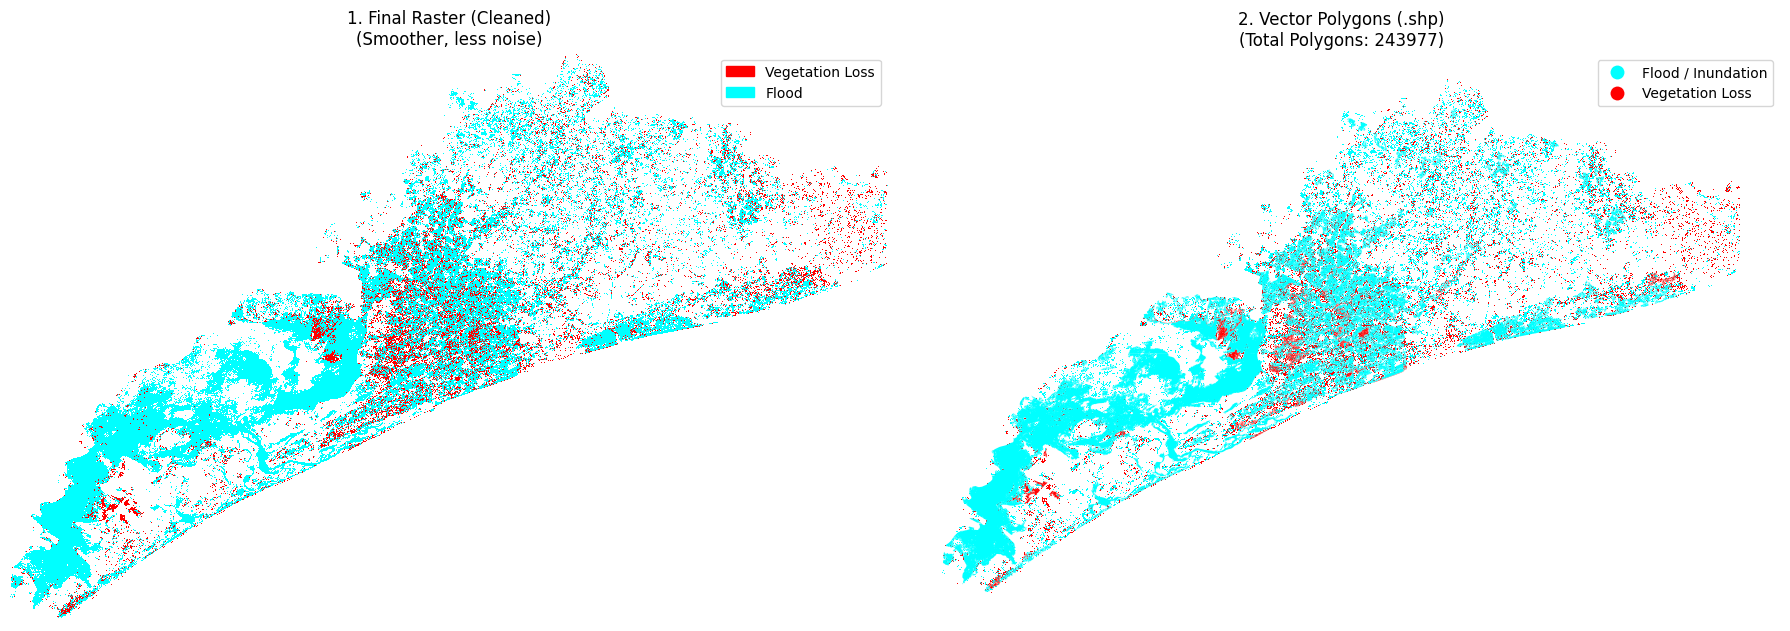

In [ ]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# --- FILES TO VIEW ---
raster_file = "Final_Damage_Cleaned.tif"
vector_file = "Cyclone_Damage_Polygons.shp"

print("Loading files for visualization...")

# 1. SETUP PLOT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# --- LEFT: CLEANED RASTER ---
try:
    with rasterio.open(raster_file) as src:
        # Read the single band (Damage Class)
        # Downsample slightly for fast plotting
        img = src.read(1)[::5, ::5]

        # Color Map: 0=White, 1=Red, 2=Cyan
        cmap = ListedColormap(['white', 'red', 'cyan'])

        ax1.imshow(img, cmap=cmap, interpolation='nearest')
        ax1.set_title("1. Final Raster (Cleaned)\n(Smoother, less noise)")
        ax1.axis('off')

        # Legend
        patches = [
            mpatches.Patch(color='red', label='Vegetation Loss'),
            mpatches.Patch(color='cyan', label='Flood')
        ]
        ax1.legend(handles=patches, loc='upper right')

except Exception as e:
    ax1.text(0.5, 0.5, f"Error: {e}", ha='center')

# --- RIGHT: SHAPEFILE POLYGONS ---
try:
    print(f"Reading Shapefile {vector_file}... (This might take a moment)")
    gdf = gpd.read_file(vector_file)

    # Check if there is data
    if len(gdf) > 0:
        # Plotting 240,000 polygons is slow! We will plot a random subset or simplify.
        # Plotting the whole thing:
        gdf.plot(column='Damage_Typ',
                 ax=ax2,
                 cmap=ListedColormap(['cyan', 'red']), # Cyan=Flood, Red=Veg
                 legend=True,
                 linewidth=0.1) # Thin lines for detail

        ax2.set_title(f"2. Vector Polygons (.shp)\n(Total Polygons: {len(gdf)})")
        ax2.axis('off')
    else:
        ax2.text(0.5, 0.5, "Shapefile is empty", ha='center')

except Exception as e:
    ax2.text(0.5, 0.5, f"Error reading Shapefile: {e}", ha='center')

plt.tight_layout()
plt.show()

Generating visual map...


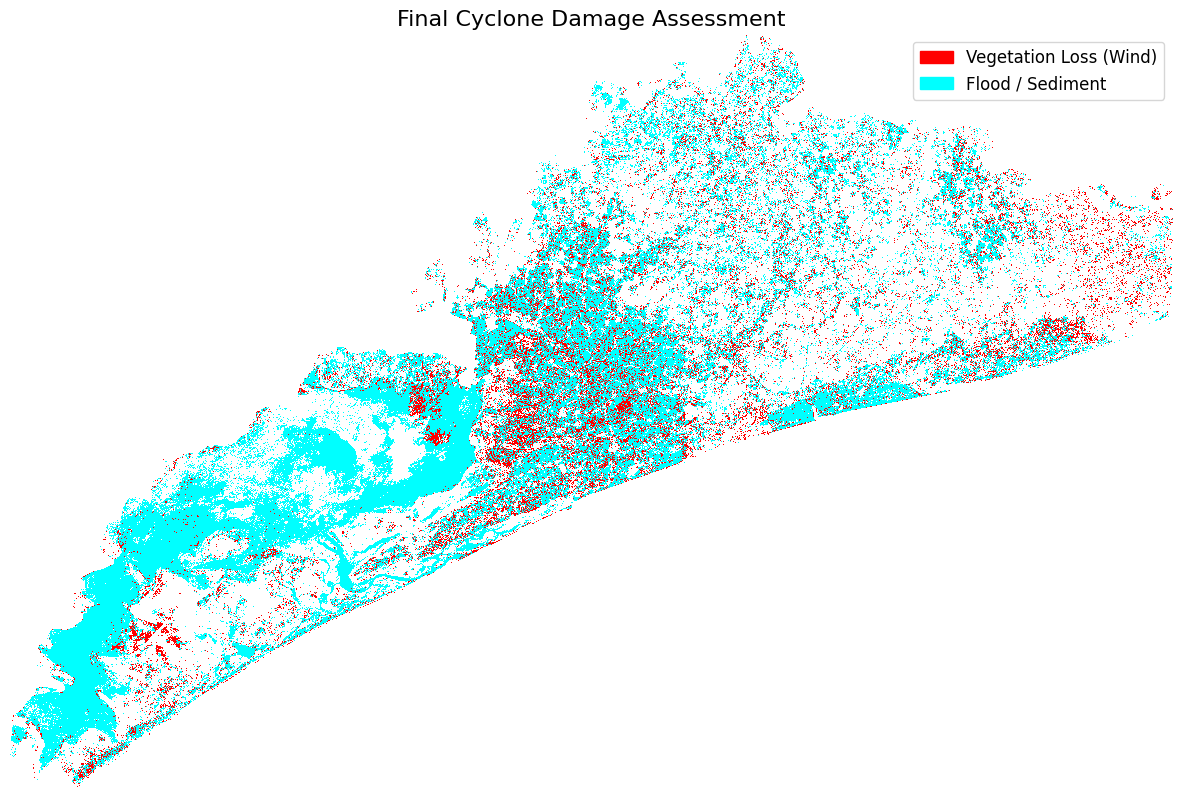

✅ Visual saved as: Final_Visual_Map.png

   SCIENTIFIC DAMAGE REPORT (Square Kilometers)
       Damage Category Pixel Count Area (Hectares)   Area (km²)
Vegetation Loss (Wind)   3,398,246    33,982.46 ha   339.82 km²
    Flood / Inundation  11,434,014   114,340.14 ha 1,143.40 km²
TOTAL DAMAGED AREA: 1,483.23 km²


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import pandas as pd

# --- CONFIGURATION ---
input_file = "Final_Cyclone_Damage_Map.tif" # Or use "Final_Damage_Cleaned.tif" if you ran the cleaning step
PIXEL_SIZE = 10  # Sentinel-2 resolution (10 meters)

# --- 1. LOAD DATA ---
try:
    with rasterio.open(input_file) as src:
        # Read the image data (Band 1)
        # We read the full resolution to ensure the map looks sharp like your image
        data = src.read(1)

        # --- 2. GENERATE VISUAL MAP (Matching your Image) ---
        print("Generating visual map...")

        # Create a large figure to match the detail
        fig, ax = plt.subplots(figsize=(15, 10))

        # Define the exact colors from your example image:
        # 0 = White (Background)
        # 1 = Red (Vegetation Loss)
        # 2 = Cyan (Flood)
        cmap = ListedColormap(['white', 'red', 'cyan'])

        # Plot the data
        # We use nearest interpolation to keep the pixels sharp (no blurring)
        ax.imshow(data, cmap=cmap, interpolation='nearest')

        # Add the Legend (Top Right)
        patches = [
            mpatches.Patch(color='red', label='Vegetation Loss (Wind)'),
            mpatches.Patch(color='cyan', label='Flood / Sediment')
        ]
        # 'loc=1' puts it in the upper right
        ax.legend(handles=patches, loc='upper right', fontsize=12, frameon=True, facecolor='white')

        # Add Title and Remove Axes
        ax.set_title("Final Cyclone Damage Assessment", fontsize=16)
        ax.axis('off') # Hides the x/y numbers

        # Save exact copy of the map
        plt.savefig("Final_Visual_Map.png", dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Visual saved as: Final_Visual_Map.png")

        # --- 3. CALCULATE LOSSES IN KM² ---
        print("\n" + "="*45)
        print("   SCIENTIFIC DAMAGE REPORT (Square Kilometers)")
        print("="*45)

        # Count pixels
        count_veg   = np.sum(data == 1)
        count_flood = np.sum(data == 2)

        # Conversion Logic:
        # 1 Pixel = 10m x 10m = 100 m²
        # 1 km² = 1,000,000 m²
        # Formula: (Count * 100) / 1,000,000

        area_veg_km2   = (count_veg * 100) / 1_000_000
        area_flood_km2 = (count_flood * 100) / 1_000_000

        # Create a Data Table
        stats = pd.DataFrame({
            "Damage Category": ["Vegetation Loss (Wind)", "Flood / Inundation"],
            "Pixel Count": [f"{count_veg:,}", f"{count_flood:,}"],
            "Area (Hectares)": [f"{area_veg_km2 * 100:,.2f} ha", f"{area_flood_km2 * 100:,.2f} ha"],
            "Area (km²)": [f"{area_veg_km2:,.2f} km²", f"{area_flood_km2:,.2f} km²"]
        })

        print(stats.to_string(index=False))
        print("="*45)
        print(f"TOTAL DAMAGED AREA: {area_veg_km2 + area_flood_km2:,.2f} km²")
        print("="*45)

except FileNotFoundError:
    print(f"❌ Error: Could not find '{input_file}'. Please make sure the file exists.")